# Chapter 10: Basic Neural Nets with Keras

In [1]:
# Libraries

import sklearn
import tensorflow as tf
import numpy as np

# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## 1. Basic Perceptron NNs

### 1.1 Single Layer NN

#### 1.1.1 Model construction using sklearn

In [2]:
# Load iris dataset

from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]
y = (iris.target == 0).astype(np.int)

__Note__ : `sklearn` `Perceptron()` is the same as `SGDClassifier` (GD logistic regression)

In [3]:
# Construct the single-layer NN

per_clf = Perceptron(max_iter = 1000, tol = 1e-3, random_state = 42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [4]:
y_pred

array([1])

#### 1.1.2 Plot the decision boundary

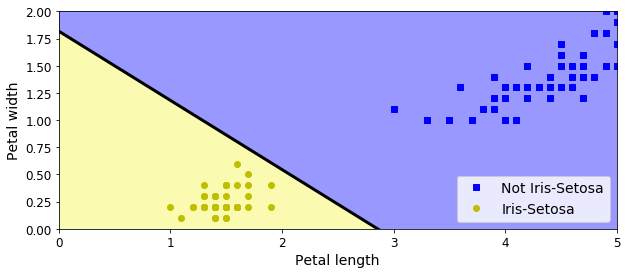

In [5]:
a = -per_clf.coef_[0][0]/per_clf.coef_[0][1]
b = -per_clf.intercept_/per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

plt.show()

### 1.2 Activation Functions

#### 1.2.1 Common activations

In [6]:
# Define the major functions

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps = 0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

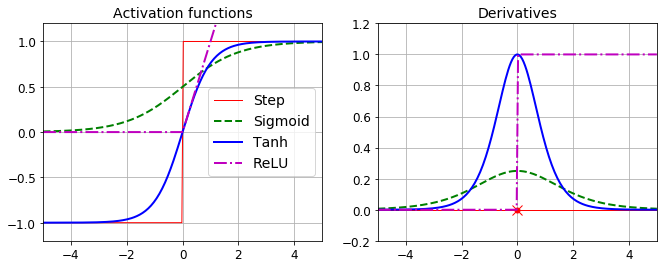

In [7]:
# Plot the activation functions

z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

#### 1.2.2 Heaviside vs. sigmoid

In [8]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation = heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

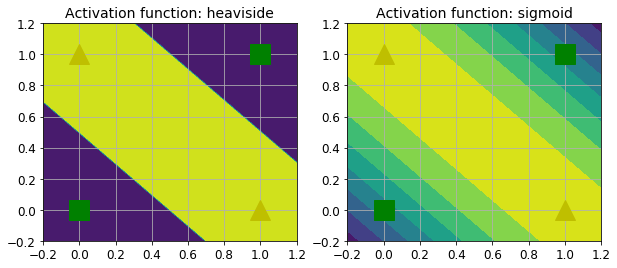

In [9]:
# Plot the functions

x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

## 2. Implementing MLP with Keras

In [10]:
# Preliminaries
from tensorflow import keras

tf.__version__

'2.3.0'

In [11]:
keras.__version__

'2.4.0'

### 2.1 Classification MLP

#### 2.1.1 Preliminaries

In [12]:
# Load dataset with keras

fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [13]:
# Images are 28x28x1 -- 784 when flattened

X_train_full.shape

(60000, 28, 28)

In [14]:
X_train_full.dtype

dtype('uint8')

In [15]:
# Split train set into train & val, and scale colors to [0, 1]

X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

X_test = X_test / 255.0

#### 2.1.2 Data exploration

In [16]:
# Fashion MNIST has many classes:

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

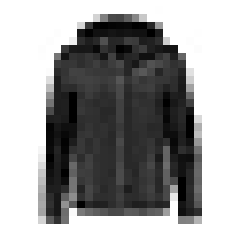

In [17]:
# Plot an image using imshow()

plt.imshow(X_train[0], cmap = "binary")
plt.axis('off')
plt.show()

In [18]:
y_train # the classes are numeric currently

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [19]:
class_names[y_train[0]] # coat image above

'Coat'

In [20]:
X_valid.shape

(5000, 28, 28)

In [21]:
X_test.shape

(10000, 28, 28)

__Quick summary__ :
   - _Train_ : 55k images
   - _Val_ : 5k images
   - _Test_ : 10k images

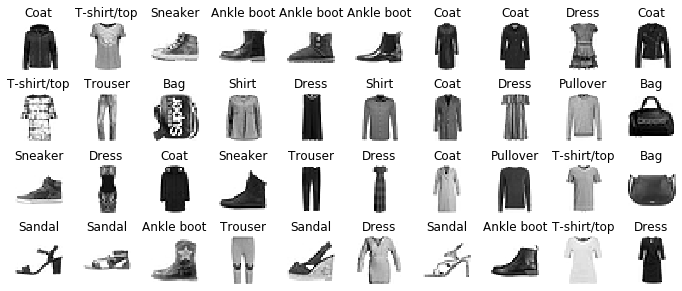

In [22]:
# Further examine a sample of images from the dataset

n_rows = 4
n_cols = 10

plt.figure(figsize = (n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap = "binary", interpolation = "nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize = 12)
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
plt.show()

#### 2.1.3 Build the model -- sequential API

In [23]:
# Make sure everything is clean

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

__Can build the model as follows__ :

```
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28, 28])) # flatten the images
model.add(keras.layers.Dense(300, activation = "relu")) # relu first layer
model.add(keras.layers.Dense(100, activation = "relu")) # another relu layer
model.add(keras.layers.Dense(10, activation = "softmax")) # classification output layer
```

__Note__ : `keras.layers.Flatten(...)` computes `X.reshape(-1, 1)` -- need to specify input shape

In [24]:
# Alternative way to specify the above model:

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [25]:
# Look at model summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [26]:
# List of model layers

model.layers

In [27]:
# Can also fetch layers by name

hidden1 = model.layers[1]
hidden1.name

'dense'

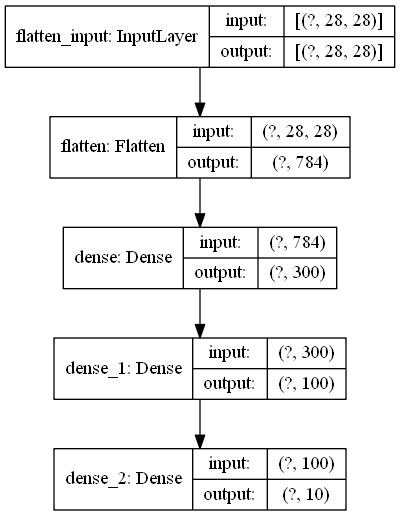

In [28]:
keras.utils.plot_model(model, show_shapes = True)

In [29]:
# Check weights and biases

weights, biases = hidden1.get_weights()

In [30]:
weights # random init

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [31]:
weights.shape

(784, 300)

In [32]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [33]:
biases.shape

(300,)

#### 2.1.4 Train the model

In [34]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

__Alternatively__ :

```
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy]) 
              ```

In [35]:
# Note - in this version of keras, it displays the steps and not the samples!

history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 2s 931us/step - loss: 0.7237 - accuracy: 0.7643 - val_loss: 0.5213 - val_accuracy: 0.8226
Epoch 2/30
1719/1719 [==============================] - 2s 880us/step - loss: 0.4842 - accuracy: 0.8317 - val_loss: 0.4349 - val_accuracy: 0.8528
Epoch 3/30
1719/1719 [==============================] - 2s 889us/step - loss: 0.4392 - accuracy: 0.8456 - val_loss: 0.5304 - val_accuracy: 0.7992
Epoch 4/30
1719/1719 [==============================] - 1s 868us/step - loss: 0.4123 - accuracy: 0.8565 - val_loss: 0.3917 - val_accuracy: 0.8646
Epoch 5/30
1719/1719 [==============================] - 1s 858us/step - loss: 0.3938 - accuracy: 0.8621 - val_loss: 0.3743 - val_accuracy: 0.8692
Epoch 6/30
1719/1719 [==============================] - 1s 872us/step - loss: 0.3752 - accuracy: 0.8676 - val_loss: 0.3703 - val_accuracy: 0.8728
Epoch 7/30
1719/1719 [==============================] - 2s 876us/step - loss: 0.3631 - accuracy: 0.8714 - val_loss: 0.3623 -

In [36]:
# Check the parameters

history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [37]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [38]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

#### 2.1.5 Results

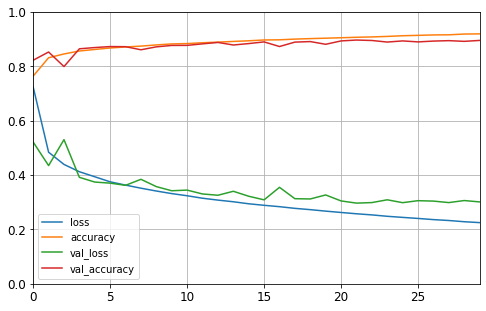

In [39]:
# Plot training

import pandas as pd

pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range for accuracy
plt.show()

In [40]:
# Check test set results

model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 641us/step - loss: 0.3355 - accuracy: 0.8827


[0.3355332911014557, 0.8827000260353088]

In [41]:
# Test on some specific test data

X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0.96],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [42]:
# Predictions

y_pred = model.predict_classes(X_new)
y_pred

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([9, 2, 1], dtype=int64)

In [43]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [44]:
y_new = y_test[:3]
y_new # matches up!

array([9, 2, 1], dtype=uint8)

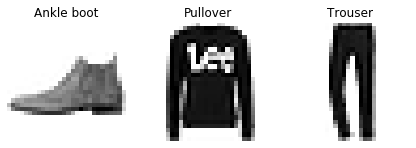

In [45]:
# Plot the images with classifications

plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

### 2.2 Regression MLP

#### 2.2.1 Preliminaries

In [46]:
# Use California housing dataset

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

# Train/val/test split
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state = 42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state = 42)

# Scale the inputs
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.fit_transform(X_test)

In [47]:
# Set seeds

np.random.seed(42)
tf.random.set_seed(42)

#### 2.2.2 Training

In [48]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation = "relu", input_shape = X_train.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss = "mean_squared_error", optimizer = keras.optimizers.SGD(lr = 1e-3))
history = model.fit(X_train, y_train, epochs = 20, validation_data = (X_valid, y_valid))

Epoch 1/20
363/363 [==============================] - 0s 655us/step - loss: 1.6419 - val_loss: 0.8077
Epoch 2/20
363/363 [==============================] - 0s 505us/step - loss: 0.7047 - val_loss: 0.6736
Epoch 3/20
363/363 [==============================] - 0s 500us/step - loss: 0.6345 - val_loss: 0.6243
Epoch 4/20
363/363 [==============================] - 0s 514us/step - loss: 0.5977 - val_loss: 0.5977
Epoch 5/20
363/363 [==============================] - 0s 506us/step - loss: 0.5706 - val_loss: 0.5708
Epoch 6/20
363/363 [==============================] - 0s 507us/step - loss: 0.5472 - val_loss: 0.5538
Epoch 7/20
363/363 [==============================] - 0s 527us/step - loss: 0.5288 - val_loss: 0.5370
Epoch 8/20
363/363 [==============================] - 0s 505us/step - loss: 0.5130 - val_loss: 0.5257
Epoch 9/20
363/363 [==============================] - 0s 503us/step - loss: 0.4992 - val_loss: 0.5142
Epoch 10/20
363/363 [==============================] - 0s 515us/step - loss: 0.487

In [49]:
# Evaluate on test set

mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

162/162 [==============================] - 0s 351us/step - loss: 0.4190


In [50]:
y_pred

array([[0.32761034],
       [1.7185787 ],
       [3.3415675 ]], dtype=float32)

In [51]:
y_test[:3]

array([0.477  , 0.458  , 5.00001])

#### 2.2.3 Plot results

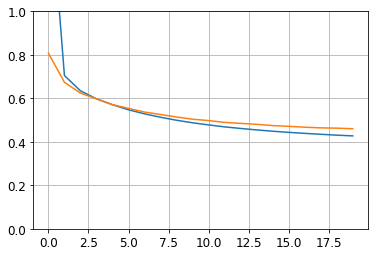

In [52]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## 3. Advanced NN Model Building

### 3.1 Functional API

#### 3.1.1 Basic wide and deep network

Consider the _Wide & Deep_ neural net that has both a deep path and short path, allowing the feed-forward network to learn different levels of patterns...

In [53]:
# Preliminaries

np.random.seed(42)
tf.random.set_seed(42)

In [54]:
# Use California housing data

input_ = keras.layers.Input(shape = X_train.shape[1:])

# The deep path
hidden1 = keras.layers.Dense(30, activation = "relu")(input_)
hidden2 = keras.layers.Dense(30, activation = "relu")(hidden1)

# Short path merged with results from deep path
concat = keras.layers.Concatenate()([input_, hidden2])

# Output and final model
output = keras.layers.Dense(1)(concat)
model = keras.Model(inputs = [input_], outputs = [output])

In [55]:
# Model summary

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           930         dense_5[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_6[0][0]         

In [56]:
# Run the model

model.compile(loss = "mean_squared_error", optimizer = keras.optimizers.SGD(lr = 1e-3))

history = model.fit(X_train, y_train, epochs = 20, validation_data = (X_valid, y_valid))

Epoch 1/20
363/363 [==============================] - 0s 736us/step - loss: 1.2611 - val_loss: 0.7115
Epoch 2/20
363/363 [==============================] - 0s 537us/step - loss: 0.6580 - val_loss: 0.6351
Epoch 3/20
363/363 [==============================] - 0s 565us/step - loss: 0.5878 - val_loss: 0.5926
Epoch 4/20
363/363 [==============================] - 0s 607us/step - loss: 0.5582 - val_loss: 0.5727
Epoch 5/20
363/363 [==============================] - 0s 588us/step - loss: 0.5347 - val_loss: 0.5501
Epoch 6/20
363/363 [==============================] - 0s 588us/step - loss: 0.5158 - val_loss: 0.5337
Epoch 7/20
363/363 [==============================] - 0s 544us/step - loss: 0.5002 - val_loss: 0.5209
Epoch 8/20
363/363 [==============================] - 0s 533us/step - loss: 0.4876 - val_loss: 0.5110
Epoch 9/20
363/363 [==============================] - 0s 535us/step - loss: 0.4760 - val_loss: 0.4997
Epoch 10/20
363/363 [==============================] - 0s 539us/step - loss: 0.465

In [57]:
mse_test = model.evaluate(X_test, y_test)

mse_test

162/162 [==============================] - 0s 363us/step - loss: 0.4122


0.4121592938899994

In [58]:
y_pred = model.predict(X_new)

y_pred

array([[0.3919998],
       [1.9343274],
       [3.6921172]], dtype=float32)

#### 3.1.2 Advanced wide and deep network

Here, send different inputs through wide/deep paths!

Send 5 features ($x_0$ to $x_4$) to the end and 6 features ($x_2$ to $x_7$) through the deep path -- note that 3 features ($x_2, \, x_3, \, x_4$) go through both

In [59]:
# Setup

np.random.seed(42)
tf.random.set_seed(42)

In [60]:
# Model building

# Inputs
input_A = keras.layers.Input(shape = [5], name = "wide_input")
input_B = keras.layers.Input(shape = [6], name = "deep_input")

# Deep path for input_B
hidden1 = keras.layers.Dense(30, activation = "relu")(input_B)
hidden2 = keras.layers.Dense(30, activation = "relu")(hidden1)

# Concat the wide input_A and deep path of input_B
concat = keras.layers.concatenate([input_A, hidden2])

# Model output
output = keras.layers.Dense(1, name = "output")(concat)
model = keras.models.Model(inputs = [input_A, input_B], outputs = [output])

In [61]:
# Compile the model
model.compile(loss = "mse", optimizer = keras.optimizers.SGD(lr = 1e-3))

# Split sets into group A (wide) and group B (deep)
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_new[:, :5], X_new[:, 2:]

In [62]:
# Run the model

history = model.fit((X_train_A, X_train_B), y_train, epochs = 20,
                   validation_data = ((X_valid_A, X_valid_B), y_valid))

Epoch 1/20
363/363 [==============================] - 0s 767us/step - loss: 1.8145 - val_loss: 0.8058
Epoch 2/20
363/363 [==============================] - 0s 561us/step - loss: 0.6771 - val_loss: 0.6472
Epoch 3/20
363/363 [==============================] - 0s 574us/step - loss: 0.5979 - val_loss: 0.5949
Epoch 4/20
363/363 [==============================] - 0s 574us/step - loss: 0.5584 - val_loss: 0.5758
Epoch 5/20
363/363 [==============================] - 0s 581us/step - loss: 0.5334 - val_loss: 0.5498
Epoch 6/20
363/363 [==============================] - 0s 576us/step - loss: 0.5120 - val_loss: 0.5382
Epoch 7/20
363/363 [==============================] - 0s 578us/step - loss: 0.4970 - val_loss: 0.5231
Epoch 8/20
363/363 [==============================] - 0s 558us/step - loss: 0.4843 - val_loss: 0.5140
Epoch 9/20
363/363 [==============================] - 0s 561us/step - loss: 0.4730 - val_loss: 0.5078
Epoch 10/20
363/363 [==============================] - 0s 566us/step - loss: 0.464

In [63]:
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
mse_test

162/162 [==============================] - 0s 406us/step - loss: 0.4302


0.430185467004776

#### 3.1.3 Add regularization

In [64]:
np.random.seed(42)
tf.random.set_seed(42)

In [65]:
# Model building

# Inputs
input_A = keras.layers.Input(shape = [5], name = "wide_input")
input_B = keras.layers.Input(shape = [6], name = "deep_input")

# Deep path for input_B
hidden1 = keras.layers.Dense(30, activation = "relu")(input_B)
hidden2 = keras.layers.Dense(30, activation = "relu")(hidden1)

# Concat the wide input_A and deep path of input_B
concat = keras.layers.concatenate([input_A, hidden2])

# Model output
output = keras.layers.Dense(1, name = "output")(concat)
aux_output = keras.layers.Dense(1, name = "aux_output")(hidden2) # output just from the deep part
model = keras.models.Model(inputs = [input_A, input_B], outputs = [output, aux_output])

In [66]:
# Compile the model

model.compile(loss = ["mse", "mse"], loss_weights = [0.9, 0.1], optimizer = keras.optimizers.SGD(lr = 1e-3))

In [67]:
# Run

history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs = 20,
                   validation_data = ([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 0s 899us/step - loss: 2.1365 - output_loss: 1.9196 - aux_output_loss: 4.0890 - val_loss: 1.0637 - val_output_loss: 0.8428 - val_aux_output_loss: 3.0523
Epoch 2/20
363/363 [==============================] - 0s 661us/step - loss: 0.8905 - output_loss: 0.6969 - aux_output_loss: 2.6326 - val_loss: 0.8088 - val_output_loss: 0.6640 - val_aux_output_loss: 2.1118
Epoch 3/20
363/363 [==============================] - 0s 668us/step - loss: 0.7429 - output_loss: 0.6088 - aux_output_loss: 1.9499 - val_loss: 0.7181 - val_output_loss: 0.6067 - val_aux_output_loss: 1.7205
Epoch 4/20
363/363 [==============================] - 0s 640us/step - loss: 0.6771 - output_loss: 0.5691 - aux_output_loss: 1.6485 - val_loss: 0.6805 - val_output_loss: 0.5852 - val_aux_output_loss: 1.5382
Epoch 5/20
363/363 [==============================] - 0s 673us/step - loss: 0.6381 - output_loss: 0.5434 - aux_output_loss: 1.4911 - val_loss: 0.6453 - val_output_loss: 0.5577 

In [68]:
# Final evaluation

total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])

y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

162/162 [==============================] - 0s 457us/step - loss: 0.4752 - output_loss: 0.4278 - aux_output_loss: 0.9021


### 3.2 Subclassing API for Dynamic Models

- _Sequential_ & _Dynamic_ APIs are declarative -- declare layers & connections first, and then feed data
    - Pros: Model easy to save/clone/share, easy to analyze structure, framework can infer shapes & check types (easy to see errors early), easy to debug
    - Cons: static; hard to deal with loops, varying shapes, conditional branching, & other dynamic behaviors
    
- _Subclassing API_ : imperative programming

__Subclassing API__ :
   1. Subclass the `Model` class
   2. Create needed layers in the constructor
   2. Use them to perform desired computations in `call()` method

In [69]:
# Example: Wide and Deep Model equivalent to sequential API

class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [70]:
# Run the above model

model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Epoch 1/10
363/363 [==============================] - 0s 923us/step - loss: 2.3298 - output_1_loss: 2.2186 - output_2_loss: 3.3304 - val_loss: 1.1282 - val_output_1_loss: 1.0043 - val_output_2_loss: 2.2438
Epoch 2/10
363/363 [==============================] - 0s 667us/step - loss: 0.9714 - output_1_loss: 0.8543 - output_2_loss: 2.0252 - val_loss: 0.8753 - val_output_1_loss: 0.7735 - val_output_2_loss: 1.7918
Epoch 3/10
363/363 [==============================] - 0s 673us/step - loss: 0.8268 - output_1_loss: 0.7289 - output_2_loss: 1.7082 - val_loss: 0.7911 - val_output_1_loss: 0.7003 - val_output_2_loss: 1.6079
Epoch 4/10
363/363 [==============================] - 0s 669us/step - loss: 0.7636 - output_1_loss: 0.6764 - output_2_loss: 1.5477 - val_loss: 0.7445 - val_output_1_loss: 0.6603 - val_output_2_loss: 1.5025
Epoch 5/10
363/363 [==============================] - 0s 670us/step - loss: 0.7211 - output_1_loss: 0.6402 - output_2_loss: 1.4489 - val_loss: 0.7090 - val_output_1_loss: 0.628

## 4. Model Logistics

### 4.1 Saving and Restoring a Model

In [71]:
# Setup

np.random.seed(42)
tf.random.set_seed(42)

In [72]:
# Build toy model

model = keras.models.Sequential([
    keras.layers.Dense(30, activation = "relu", input_shape = [8]),
    keras.layers.Dense(30, activation = "relu"),
    keras.layers.Dense(1)
])

In [73]:
# Run the model

model.compile(loss = "mse", optimizer = keras.optimizers.SGD(lr = 1e-3))
history = model.fit(X_train, y_train, epochs = 10, validation_data = (X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 0s 694us/step - loss: 1.8866 - val_loss: 0.7414
Epoch 2/10
363/363 [==============================] - 0s 530us/step - loss: 0.6577 - val_loss: 0.6221
Epoch 3/10
363/363 [==============================] - 0s 537us/step - loss: 0.5934 - val_loss: 0.5779
Epoch 4/10
363/363 [==============================] - 0s 533us/step - loss: 0.5557 - val_loss: 0.5572
Epoch 5/10
363/363 [==============================] - 0s 536us/step - loss: 0.5272 - val_loss: 0.5305
Epoch 6/10
363/363 [==============================] - 0s 533us/step - loss: 0.5033 - val_loss: 0.5113
Epoch 7/10
363/363 [==============================] - 0s 528us/step - loss: 0.4854 - val_loss: 0.4974
Epoch 8/10
363/363 [==============================] - 0s 528us/step - loss: 0.4709 - val_loss: 0.4903
Epoch 9/10
363/363 [==============================] - 0s 542us/step - loss: 0.4578 - val_loss: 0.4773
Epoch 10/10
162/162 [==============================] - 0s 361us/step - loss: 0.435

In [74]:
# Save the model

model.save("my_keras_model.h5") # HDF5 format saves architecture and values of all parameters
# Note - also saves the optimizer, parameters, and state!

In [75]:
# Load the model

model = keras.models.load_model("my_keras_model.h5")

In [76]:
model.predict(X_new)

array([[0.4736449],
       [1.6739202],
       [3.142792 ]], dtype=float32)

In [77]:
# Can also save weights

model.save_weights("my_keras_weights.ckpt")

In [78]:
# Can load them back

model.load_weights("my_keras_weights.ckpt")

### 4.2 Using Callbacks During Training

`fit()` accepts `callbacks` argument for list of objects called at:
   - Start and end of training
   - Start and end of each epoch
   - Even before/after processing each batch!
   
_Example_ : `ModelCheckpoint` callback saves checkpoints at regular intervals during training (default = end of each epoch)

In [79]:
keras.backend.clear_session()

In [80]:
np.random.seed(42)
tf.random.set_seed(42)

In [81]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation = "relu", input_shape = [8]),
    keras.layers.Dense(30, activation = "relu"),
    keras.layers.Dense(1)
])

#### 4.2.1 Checkpoints during training

In [82]:
# Save checkpoint at each epoch

model.compile(loss = "mse", optimizer = keras.optimizers.SGD(lr = 1e-3))

# Only save model if it gets best performance on val set so far
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only = True)

history = model.fit(X_train, y_train, epochs = 10,
                   validation_data = (X_valid, y_valid),
                   callbacks = [checkpoint_cb])

model = keras.models.load_model("my_keras_model.h5") # rollback to the best model -- basically early stopping

mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 0s 723us/step - loss: 1.8866 - val_loss: 0.7414
Epoch 2/10
363/363 [==============================] - 0s 563us/step - loss: 0.6577 - val_loss: 0.6221
Epoch 3/10
363/363 [==============================] - 0s 555us/step - loss: 0.5934 - val_loss: 0.5779
Epoch 4/10
363/363 [==============================] - 0s 648us/step - loss: 0.5557 - val_loss: 0.5572
Epoch 5/10
363/363 [==============================] - 0s 552us/step - loss: 0.5272 - val_loss: 0.5305
Epoch 6/10
363/363 [==============================] - 0s 568us/step - loss: 0.5033 - val_loss: 0.5113
Epoch 7/10
363/363 [==============================] - 0s 555us/step - loss: 0.4854 - val_loss: 0.4974
Epoch 8/10
363/363 [==============================] - 0s 555us/step - loss: 0.4709 - val_loss: 0.4903
Epoch 9/10
363/363 [==============================] - 0s 568us/step - loss: 0.4578 - val_loss: 0.4773
Epoch 10/10
162/162 [==============================] - 0s 365us/step - loss: 0.435

#### 4.2.2 Actual early stopping

In [83]:
# Save checkpoint at each epoch

model.compile(loss = "mse", optimizer = keras.optimizers.SGD(lr = 1e-3))

# Interrupts training when no progress made on val set for "patience" number of epochs, then rolls back to best model
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

history = model.fit(X_train, y_train, epochs = 100,
                   validation_data = (X_valid, y_valid),
                   callbacks = [checkpoint_cb, early_stopping_cb])

mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 0s 735us/step - loss: 0.4393 - val_loss: 0.4655
Epoch 2/100
363/363 [==============================] - 0s 562us/step - loss: 0.4315 - val_loss: 0.4627
Epoch 3/100
363/363 [==============================] - 0s 562us/step - loss: 0.4259 - val_loss: 0.4562
Epoch 4/100
363/363 [==============================] - 0s 579us/step - loss: 0.4201 - val_loss: 0.4554
Epoch 5/100
363/363 [==============================] - 0s 566us/step - loss: 0.4154 - val_loss: 0.4506
Epoch 6/100
363/363 [==============================] - 0s 564us/step - loss: 0.4111 - val_loss: 0.4461
Epoch 7/100
363/363 [==============================] - 0s 569us/step - loss: 0.4074 - val_loss: 0.4446
Epoch 8/100
363/363 [==============================] - 0s 577us/step - loss: 0.4040 - val_loss: 0.4434
Epoch 9/100
363/363 [==============================] - 0s 575us/step - loss: 0.4008 - val_loss: 0.4391
Epoch 10/100
363/363 [==============================] - 0s 569us/step - l

162/162 [==============================] - 0s 382us/step - loss: 0.3720


#### 4.2.3 Custom callbacks

_Example_ : display ratio between val loss and training loss during training to detect overfitting

In [84]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"]/logs["loss"]))

In [85]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs = 1,
                   validation_data = (X_valid, y_valid),
                   callbacks = [val_train_ratio_cb])

247/363 [===================>..........] - ETA: 0s - loss: 0.3398
val/train: 1.20
363/363 [==============================] - 0s 591us/step - loss: 0.3373 - val_loss: 0.4052


### 4.3 TensorBoard

#### 4.3.1 Run from directory

In [86]:
import os

root_logdir = os.path.join(os.curdir, "my_logs")

In [87]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d=%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2020_09_07=17_43_18'

In [88]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [89]:
# Toy model

model = keras.models.Sequential([
    keras.layers.Dense(30, activation = "relu", input_shape = [8]),
    keras.layers.Dense(30, activation = "relu"),
    keras.layers.Dense(1)
])

model.compile(loss = "mse", optimizer = keras.optimizers.SGD(lr = 0.05))

In [90]:
# Init TensorBoard

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs = 30,
                   validation_data = (X_valid, y_valid),
                   callbacks = [checkpoint_cb, tensorboard_cb])

Epoch 1/30
  1/363 [..............................] - ETA: 0s - loss: 7.8215WARNING:tensorflow:From C:\Users\rschm\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
363/363 [==============================] - 0s 793us/step - loss: 0.5530 - val_loss: 3.4409
Epoch 2/30
363/363 [==============================] - 0s 577us/step - loss: 5292745216.0000 - val_loss: 1.3230
Epoch 3/30
363/363 [==============================] - 0s 579us/step - loss: 1.3411 - val_loss: 1.3176
Epoch 4/30
363/363 [==============================] - 0s 571us/step - loss: 1.3423 - val_loss: 1.3261
Epoch 5/30
363/363 [==============================] - 0s 621us/step - loss: 1.3423 - val_loss: 1.3154
Epoch 6/30
363/363 [==============================] - 0s 547us/step - loss: 1.3431 - val_loss: 1.3203
Epoch 7/30
363

__Commands that worked on my PC__ :
   1. Navigate to folder on cmd line
   2. Run `python -m tensorboard.main --logdir={dir}`

In [107]:
# Other logging options

help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module tensorflow.python.keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



## 5. Hyperparameter Tuning

In [114]:
# Setup

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

To employ `GridSearchCV` or `RandomizedSearchCV` from `sklearn`, need to wrap Keras model in object to  mimic regular `sklearn` regressors -- first, create a function that will build & compile Karas model given set of hyperparams

In [115]:
def build_model(n_hidden = 1, n_neurons = 30, learning_rate = 3e-3, input_shape = [8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape = input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation = "relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr = learning_rate)
    model.compile(loss = "mse", optimizer = optimizer)
    return model

In [116]:
# Create KerasRegressor based on build_model()

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

__Notes__ :
   - `KerasRegressor` is thin wrapper around Keras model build using `build_model`
   - Uses default hyperparams since none specified
   - Fit like regular sklearn regressor -- train using `fit()`, predict using `predict()`, and eval using `score()`

In [117]:
# Fit the model with early stopping

keras_reg.fit(X_train, y_train, epochs = 100,
             validation_data = (X_valid, y_valid),
             callbacks = [keras.callbacks.EarlyStopping(patience = 10)])

Epoch 1/100
363/363 [==============================] - 0s 642us/step - loss: 1.0896 - val_loss: 0.8275
Epoch 2/100
363/363 [==============================] - 0s 512us/step - loss: 0.7606 - val_loss: 0.6074
Epoch 3/100
363/363 [==============================] - 0s 503us/step - loss: 0.5456 - val_loss: 0.5189
Epoch 4/100
363/363 [==============================] - 0s 506us/step - loss: 0.4732 - val_loss: 0.4983
Epoch 5/100
363/363 [==============================] - 0s 514us/step - loss: 0.4503 - val_loss: 0.4779
Epoch 6/100
363/363 [==============================] - 0s 519us/step - loss: 0.4338 - val_loss: 0.4677
Epoch 7/100
363/363 [==============================] - 0s 513us/step - loss: 0.4241 - val_loss: 0.4609
Epoch 8/100
363/363 [==============================] - 0s 519us/step - loss: 0.4168 - val_loss: 0.4580
Epoch 9/100
363/363 [==============================] - 0s 527us/step - loss: 0.4108 - val_loss: 0.4497
Epoch 10/100
363/363 [==============================] - 0s 533us/step - l

Epoch 80/100
363/363 [==============================] - 0s 517us/step - loss: 0.3376 - val_loss: 0.4060
Epoch 81/100
363/363 [==============================] - 0s 504us/step - loss: 0.3383 - val_loss: 0.4037
Epoch 82/100
363/363 [==============================] - 0s 504us/step - loss: 0.3371 - val_loss: 0.4063
Epoch 83/100
363/363 [==============================] - 0s 511us/step - loss: 0.3367 - val_loss: 0.4062
Epoch 84/100
363/363 [==============================] - 0s 511us/step - loss: 0.3362 - val_loss: 0.4055
Epoch 85/100
363/363 [==============================] - 0s 506us/step - loss: 0.3369 - val_loss: 0.4079
Epoch 86/100
363/363 [==============================] - 0s 508us/step - loss: 0.3359 - val_loss: 0.4061
Epoch 87/100
363/363 [==============================] - 0s 517us/step - loss: 0.3357 - val_loss: 0.4072
Epoch 88/100
363/363 [==============================] - 0s 525us/step - loss: 0.3355 - val_loss: 0.4038
Epoch 89/100
363/363 [==============================] - 0s 541us

In [118]:
# Performance

mse_test = keras_reg.score(X_test, y_test)

162/162 [==============================] - 0s 373us/step - loss: 0.3716


In [120]:
y_pred = keras_reg.predict(X_new)

y_pred

array([0.64576924, 1.6425421 , 4.783357  ], dtype=float32)

In [121]:
np.random.seed(42)
tf.random.set_seed(42)

In [123]:
# Implement randomized CV search

from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2)
}

# Do 10 rounds randomized 3-fold CV
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter = 10, cv = 3, verbose = 2)
rnd_search_cv.fit(X_train, y_train, epochs = 100,
                 validation_data = (X_valid, y_valid),
                 callbacks = [keras.callbacks.EarlyStopping(patience = 10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] learning_rate=0.001683454924600351, n_hidden=0, n_neurons=15 ....
Epoch 1/100
  1/242 [..............................] - ETA: 0s - loss: 5.5145

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


242/242 [==============================] - 0s 770us/step - loss: 3.5557 - val_loss: 1.7800
Epoch 2/100
242/242 [==============================] - 0s 565us/step - loss: 1.3347 - val_loss: 0.9091
Epoch 3/100
242/242 [==============================] - 0s 561us/step - loss: 0.8591 - val_loss: 0.7093
Epoch 4/100
242/242 [==============================] - 0s 573us/step - loss: 0.7360 - val_loss: 0.6515
Epoch 5/100
242/242 [==============================] - 0s 647us/step - loss: 0.6930 - val_loss: 0.6294
Epoch 6/100
242/242 [==============================] - 0s 550us/step - loss: 0.6668 - val_loss: 0.6103
Epoch 7/100
242/242 [==============================] - 0s 555us/step - loss: 0.6514 - val_loss: 0.5958
Epoch 8/100
242/242 [==============================] - 0s 552us/step - loss: 0.6381 - val_loss: 0.5859
Epoch 9/100
242/242 [==============================] - 0s 557us/step - loss: 0.6276 - val_loss: 0.5780
Epoch 10/100
242/242 [==============================] - 0s 561us/step - loss: 0.6125 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s remaining:    0.0s


242/242 [==============================] - 0s 770us/step - loss: 3.5605 - val_loss: 2.0194
Epoch 2/100
242/242 [==============================] - 0s 586us/step - loss: 1.4777 - val_loss: 1.1378
Epoch 3/100
242/242 [==============================] - 0s 577us/step - loss: 1.0149 - val_loss: 0.8985
Epoch 4/100
242/242 [==============================] - 0s 606us/step - loss: 0.8729 - val_loss: 0.8007
Epoch 5/100
242/242 [==============================] - 0s 603us/step - loss: 0.8027 - val_loss: 0.7459
Epoch 6/100
242/242 [==============================] - 0s 554us/step - loss: 0.7542 - val_loss: 0.7114
Epoch 7/100
242/242 [==============================] - 0s 569us/step - loss: 0.7160 - val_loss: 0.6897
Epoch 8/100
242/242 [==============================] - 0s 565us/step - loss: 0.6847 - val_loss: 0.6762
Epoch 9/100
242/242 [==============================] - 0s 577us/step - loss: 0.6588 - val_loss: 0.6686
Epoch 10/100
242/242 [==============================] - 0s 569us/step - loss: 0.6371 

242/242 [==============================] - 0s 550us/step - loss: 0.5024 - val_loss: 0.6384
Epoch 16/100
242/242 [==============================] - 0s 569us/step - loss: 0.5024 - val_loss: 0.6482
Epoch 17/100
242/242 [==============================] - 0s 552us/step - loss: 0.5005 - val_loss: 0.6304
Epoch 18/100
242/242 [==============================] - 0s 560us/step - loss: 0.5040 - val_loss: 0.6274
Epoch 19/100
242/242 [==============================] - 0s 552us/step - loss: 0.5012 - val_loss: 0.6453
Epoch 20/100
121/121 [==============================] - 0s 333us/step - loss: 0.9327
[CV]  learning_rate=0.008731907739399206, n_hidden=0, n_neurons=21, total=   3.1s
[CV] learning_rate=0.008731907739399206, n_hidden=0, n_neurons=21 ....
Epoch 1/100
242/242 [==============================] - 0s 742us/step - loss: 1.4616 - val_loss: 0.5269
Epoch 2/100
242/242 [==============================] - 0s 561us/step - loss: 0.6113 - val_loss: 0.5981
Epoch 3/100
242/242 [============================

242/242 [==============================] - 0s 645us/step - loss: 0.3671 - val_loss: 0.4297
Epoch 59/100
242/242 [==============================] - 0s 633us/step - loss: 0.3663 - val_loss: 0.4289
Epoch 60/100
242/242 [==============================] - 0s 746us/step - loss: 0.3652 - val_loss: 0.4285
Epoch 61/100
242/242 [==============================] - 0s 674us/step - loss: 0.3645 - val_loss: 0.4282
Epoch 62/100
242/242 [==============================] - 0s 684us/step - loss: 0.3636 - val_loss: 0.4282
Epoch 63/100
242/242 [==============================] - 0s 623us/step - loss: 0.3627 - val_loss: 0.4270
Epoch 64/100
242/242 [==============================] - 0s 643us/step - loss: 0.3620 - val_loss: 0.4268
Epoch 65/100
242/242 [==============================] - 0s 684us/step - loss: 0.3611 - val_loss: 0.4264
Epoch 66/100
242/242 [==============================] - 0s 672us/step - loss: 0.3605 - val_loss: 0.4260
Epoch 67/100
242/242 [==============================] - 0s 631us/step - loss:

Epoch 35/100
242/242 [==============================] - 0s 672us/step - loss: 0.4009 - val_loss: 0.4518
Epoch 36/100
242/242 [==============================] - 0s 672us/step - loss: 0.3989 - val_loss: 0.4489
Epoch 37/100
242/242 [==============================] - 0s 709us/step - loss: 0.3970 - val_loss: 0.4482
Epoch 38/100
242/242 [==============================] - 0s 635us/step - loss: 0.3951 - val_loss: 0.4468
Epoch 39/100
242/242 [==============================] - 0s 646us/step - loss: 0.3933 - val_loss: 0.4438
Epoch 40/100
242/242 [==============================] - 0s 664us/step - loss: 0.3917 - val_loss: 0.4437
Epoch 41/100
242/242 [==============================] - 0s 647us/step - loss: 0.3900 - val_loss: 0.4430
Epoch 42/100
242/242 [==============================] - 0s 635us/step - loss: 0.3885 - val_loss: 0.4422
Epoch 43/100
242/242 [==============================] - 0s 640us/step - loss: 0.3870 - val_loss: 0.4394
Epoch 44/100
242/242 [==============================] - 0s 668us

242/242 [==============================] - 0s 649us/step - loss: 0.5908 - val_loss: 0.6053
Epoch 12/100
242/242 [==============================] - 0s 639us/step - loss: 0.5749 - val_loss: 0.5915
Epoch 13/100
242/242 [==============================] - 0s 647us/step - loss: 0.5601 - val_loss: 0.5804
Epoch 14/100
242/242 [==============================] - 0s 643us/step - loss: 0.5465 - val_loss: 0.5703
Epoch 15/100
242/242 [==============================] - 0s 643us/step - loss: 0.5340 - val_loss: 0.5604
Epoch 16/100
242/242 [==============================] - 0s 630us/step - loss: 0.5225 - val_loss: 0.5491
Epoch 17/100
242/242 [==============================] - 0s 626us/step - loss: 0.5119 - val_loss: 0.5406
Epoch 18/100
242/242 [==============================] - 0s 638us/step - loss: 0.5020 - val_loss: 0.5321
Epoch 19/100
242/242 [==============================] - 0s 639us/step - loss: 0.4930 - val_loss: 0.5250
Epoch 20/100
242/242 [==============================] - 0s 639us/step - loss:

Epoch 90/100
242/242 [==============================] - 0s 651us/step - loss: 0.3594 - val_loss: 0.4260
Epoch 91/100
242/242 [==============================] - 0s 672us/step - loss: 0.3589 - val_loss: 0.4264
Epoch 92/100
242/242 [==============================] - 0s 631us/step - loss: 0.3587 - val_loss: 0.4247
Epoch 93/100
242/242 [==============================] - 0s 639us/step - loss: 0.3580 - val_loss: 0.4249
Epoch 94/100
242/242 [==============================] - 0s 631us/step - loss: 0.3577 - val_loss: 0.4252
Epoch 95/100
242/242 [==============================] - 0s 648us/step - loss: 0.3571 - val_loss: 0.4257
Epoch 96/100
242/242 [==============================] - 0s 659us/step - loss: 0.3567 - val_loss: 0.4251
Epoch 97/100
242/242 [==============================] - 0s 637us/step - loss: 0.3562 - val_loss: 0.4240
Epoch 98/100
242/242 [==============================] - 0s 642us/step - loss: 0.3558 - val_loss: 0.4237
Epoch 99/100
242/242 [==============================] - 0s 676us

242/242 [==============================] - 0s 618us/step - loss: 0.3884 - val_loss: 0.4484
Epoch 67/100
242/242 [==============================] - 0s 604us/step - loss: 0.3873 - val_loss: 0.4476
Epoch 68/100
242/242 [==============================] - 0s 614us/step - loss: 0.3864 - val_loss: 0.4476
Epoch 69/100
242/242 [==============================] - 0s 629us/step - loss: 0.3855 - val_loss: 0.4462
Epoch 70/100
242/242 [==============================] - 0s 618us/step - loss: 0.3846 - val_loss: 0.4452
Epoch 71/100
242/242 [==============================] - 0s 625us/step - loss: 0.3838 - val_loss: 0.4458
Epoch 72/100
242/242 [==============================] - 0s 680us/step - loss: 0.3829 - val_loss: 0.4453
Epoch 73/100
242/242 [==============================] - 0s 668us/step - loss: 0.3822 - val_loss: 0.4452
Epoch 74/100
242/242 [==============================] - 0s 664us/step - loss: 0.3814 - val_loss: 0.4437
Epoch 75/100
242/242 [==============================] - 0s 639us/step - loss:

Epoch 43/100
242/242 [==============================] - 0s 625us/step - loss: 0.4642 - val_loss: 0.5140
Epoch 44/100
242/242 [==============================] - 0s 605us/step - loss: 0.4605 - val_loss: 0.5122
Epoch 45/100
242/242 [==============================] - 0s 604us/step - loss: 0.4566 - val_loss: 0.5101
Epoch 46/100
242/242 [==============================] - 0s 602us/step - loss: 0.4531 - val_loss: 0.5057
Epoch 47/100
242/242 [==============================] - 0s 602us/step - loss: 0.4495 - val_loss: 0.5038
Epoch 48/100
242/242 [==============================] - 0s 599us/step - loss: 0.4459 - val_loss: 0.5007
Epoch 49/100
242/242 [==============================] - 0s 622us/step - loss: 0.4424 - val_loss: 0.4994
Epoch 50/100
242/242 [==============================] - 0s 608us/step - loss: 0.4393 - val_loss: 0.4965
Epoch 51/100
242/242 [==============================] - 0s 614us/step - loss: 0.4361 - val_loss: 0.4926
Epoch 52/100
242/242 [==============================] - 0s 624us

242/242 [==============================] - 0s 632us/step - loss: 0.5461 - val_loss: 0.5643
Epoch 20/100
242/242 [==============================] - 0s 618us/step - loss: 0.5381 - val_loss: 0.5597
Epoch 21/100
242/242 [==============================] - 0s 606us/step - loss: 0.5305 - val_loss: 0.5540
Epoch 22/100
242/242 [==============================] - 0s 626us/step - loss: 0.5234 - val_loss: 0.5491
Epoch 23/100
242/242 [==============================] - 0s 643us/step - loss: 0.5169 - val_loss: 0.5443
Epoch 24/100
242/242 [==============================] - 0s 618us/step - loss: 0.5106 - val_loss: 0.5419
Epoch 25/100
242/242 [==============================] - 0s 629us/step - loss: 0.5050 - val_loss: 0.5360
Epoch 26/100
242/242 [==============================] - 0s 617us/step - loss: 0.4996 - val_loss: 0.5323
Epoch 27/100
242/242 [==============================] - 0s 612us/step - loss: 0.4945 - val_loss: 0.5279
Epoch 28/100
242/242 [==============================] - 0s 617us/step - loss:

Epoch 98/100
242/242 [==============================] - 0s 620us/step - loss: 0.3920 - val_loss: 0.4446
Epoch 99/100
242/242 [==============================] - 0s 608us/step - loss: 0.3915 - val_loss: 0.4436
Epoch 100/100
121/121 [==============================] - 0s 371us/step - loss: 0.3897
[CV]  learning_rate=0.0003920021771415983, n_hidden=3, n_neurons=24, total=  15.5s
[CV] learning_rate=0.006010328378268217, n_hidden=0, n_neurons=2 .....
Epoch 1/100
242/242 [==============================] - 0s 754us/step - loss: 2.1013 - val_loss: 0.7344
Epoch 2/100
242/242 [==============================] - 0s 585us/step - loss: 0.8603 - val_loss: 0.9551
Epoch 3/100
242/242 [==============================] - 0s 554us/step - loss: 0.7494 - val_loss: 0.8922
Epoch 4/100
242/242 [==============================] - 0s 552us/step - loss: 1.0991 - val_loss: 2.0623
Epoch 5/100
242/242 [==============================] - 0s 561us/step - loss: 1.3388 - val_loss: 2.7556
Epoch 6/100
242/242 [================

242/242 [==============================] - 0s 585us/step - loss: 0.3623 - val_loss: 0.5511
Epoch 13/100
242/242 [==============================] - 0s 581us/step - loss: 0.3548 - val_loss: 0.5507
Epoch 14/100
242/242 [==============================] - 0s 592us/step - loss: 0.3603 - val_loss: 0.5530
Epoch 15/100
242/242 [==============================] - 0s 580us/step - loss: 0.3515 - val_loss: 0.5525
Epoch 16/100
121/121 [==============================] - 0s 366us/step - loss: 0.3621
[CV]  learning_rate=0.008339092654580042, n_hidden=1, n_neurons=38, total=   2.6s
[CV] learning_rate=0.008339092654580042, n_hidden=1, n_neurons=38 ....
Epoch 1/100
242/242 [==============================] - 0s 806us/step - loss: 0.8950 - val_loss: 0.6119
Epoch 2/100
242/242 [==============================] - 0s 573us/step - loss: 0.5223 - val_loss: 0.5152
Epoch 3/100
242/242 [==============================] - 0s 576us/step - loss: 0.4610 - val_loss: 0.4822
Epoch 4/100
242/242 [=============================

121/121 [==============================] - 0s 429us/step - loss: 0.3439
[CV]  learning_rate=0.008339092654580042, n_hidden=1, n_neurons=38, total=  10.7s
[CV] learning_rate=0.008339092654580042, n_hidden=1, n_neurons=38 ....
Epoch 1/100
242/242 [==============================] - 0s 818us/step - loss: 0.9047 - val_loss: 0.5567
Epoch 2/100
242/242 [==============================] - 0s 592us/step - loss: 0.4870 - val_loss: 0.4810
Epoch 3/100
242/242 [==============================] - 0s 573us/step - loss: 0.4394 - val_loss: 0.4723
Epoch 4/100
242/242 [==============================] - 0s 569us/step - loss: 0.5436 - val_loss: 0.6223
Epoch 5/100
242/242 [==============================] - 0s 568us/step - loss: 0.5247 - val_loss: 1.9981
Epoch 6/100
242/242 [==============================] - 0s 575us/step - loss: 0.8047 - val_loss: 0.5059
Epoch 7/100
242/242 [==============================] - 0s 585us/step - loss: 0.4359 - val_loss: 0.4614
Epoch 8/100
242/242 [==============================] -

242/242 [==============================] - 0s 622us/step - loss: 0.3275 - val_loss: 0.4039
Epoch 78/100
242/242 [==============================] - 0s 616us/step - loss: 0.3202 - val_loss: 0.3979
Epoch 79/100
242/242 [==============================] - 0s 606us/step - loss: 0.3165 - val_loss: 0.3961
Epoch 80/100
242/242 [==============================] - 0s 593us/step - loss: 0.3190 - val_loss: 0.3997
Epoch 81/100
121/121 [==============================] - 0s 363us/step - loss: 0.3188
[CV]  learning_rate=0.008339092654580042, n_hidden=1, n_neurons=38, total=  12.2s
[CV] learning_rate=0.00030107783636342726, n_hidden=3, n_neurons=21 ..
Epoch 1/100
242/242 [==============================] - 0s 948us/step - loss: 4.0446 - val_loss: 2.7996
Epoch 2/100
242/242 [==============================] - 0s 702us/step - loss: 2.3108 - val_loss: 1.7722
Epoch 3/100
242/242 [==============================] - 0s 668us/step - loss: 1.6259 - val_loss: 1.3987
Epoch 4/100
242/242 [=============================

Epoch 73/100
242/242 [==============================] - 0s 709us/step - loss: 0.4227 - val_loss: 0.4806
Epoch 74/100
242/242 [==============================] - 0s 680us/step - loss: 0.4209 - val_loss: 0.4789
Epoch 75/100
242/242 [==============================] - 0s 676us/step - loss: 0.4191 - val_loss: 0.4775
Epoch 76/100
242/242 [==============================] - 0s 602us/step - loss: 0.4172 - val_loss: 0.4755
Epoch 77/100
242/242 [==============================] - 0s 596us/step - loss: 0.4157 - val_loss: 0.4752
Epoch 78/100
242/242 [==============================] - 0s 617us/step - loss: 0.4140 - val_loss: 0.4753
Epoch 79/100
242/242 [==============================] - 0s 598us/step - loss: 0.4125 - val_loss: 0.4746
Epoch 80/100
242/242 [==============================] - 0s 609us/step - loss: 0.4108 - val_loss: 0.4720
Epoch 81/100
242/242 [==============================] - 0s 613us/step - loss: 0.4094 - val_loss: 0.4721
Epoch 82/100
242/242 [==============================] - 0s 618us

242/242 [==============================] - 0s 614us/step - loss: 0.4942 - val_loss: 0.5740
Epoch 50/100
242/242 [==============================] - 0s 616us/step - loss: 0.4906 - val_loss: 0.5705
Epoch 51/100
242/242 [==============================] - 0s 606us/step - loss: 0.4868 - val_loss: 0.5660
Epoch 52/100
242/242 [==============================] - 0s 618us/step - loss: 0.4837 - val_loss: 0.5627
Epoch 53/100
242/242 [==============================] - 0s 611us/step - loss: 0.4804 - val_loss: 0.5586
Epoch 54/100
242/242 [==============================] - 0s 608us/step - loss: 0.4771 - val_loss: 0.5550
Epoch 55/100
242/242 [==============================] - 0s 610us/step - loss: 0.4741 - val_loss: 0.5517
Epoch 56/100
242/242 [==============================] - 0s 606us/step - loss: 0.4711 - val_loss: 0.5480
Epoch 57/100
242/242 [==============================] - 0s 616us/step - loss: 0.4680 - val_loss: 0.5436
Epoch 58/100
242/242 [==============================] - 0s 610us/step - loss:

242/242 [==============================] - 0s 602us/step - loss: 0.5559 - val_loss: 0.5831
Epoch 24/100
242/242 [==============================] - 0s 609us/step - loss: 0.5491 - val_loss: 0.5784
Epoch 25/100
242/242 [==============================] - 0s 618us/step - loss: 0.5425 - val_loss: 0.5729
Epoch 26/100
242/242 [==============================] - 0s 602us/step - loss: 0.5360 - val_loss: 0.5669
Epoch 27/100
242/242 [==============================] - 0s 602us/step - loss: 0.5296 - val_loss: 0.5617
Epoch 28/100
242/242 [==============================] - 0s 607us/step - loss: 0.5234 - val_loss: 0.5563
Epoch 29/100
242/242 [==============================] - 0s 606us/step - loss: 0.5173 - val_loss: 0.5521
Epoch 30/100
242/242 [==============================] - 0s 602us/step - loss: 0.5115 - val_loss: 0.5459
Epoch 31/100
242/242 [==============================] - 0s 609us/step - loss: 0.5058 - val_loss: 0.5410
Epoch 32/100
242/242 [==============================] - 0s 616us/step - loss:

242/242 [==============================] - 0s 779us/step - loss: 1.3002 - val_loss: 1.0622
Epoch 2/100
242/242 [==============================] - 0s 560us/step - loss: 0.9964 - val_loss: 0.6384
Epoch 3/100
242/242 [==============================] - 0s 583us/step - loss: 0.5490 - val_loss: 0.5582
Epoch 4/100
242/242 [==============================] - 0s 581us/step - loss: 0.4986 - val_loss: 0.5201
Epoch 5/100
242/242 [==============================] - 0s 577us/step - loss: 0.4710 - val_loss: 0.5003
Epoch 6/100
242/242 [==============================] - 0s 569us/step - loss: 0.4526 - val_loss: 0.4898
Epoch 7/100
242/242 [==============================] - 0s 577us/step - loss: 0.4406 - val_loss: 0.4823
Epoch 8/100
242/242 [==============================] - 0s 579us/step - loss: 0.4321 - val_loss: 0.4723
Epoch 9/100
242/242 [==============================] - 0s 577us/step - loss: 0.4259 - val_loss: 0.4766
Epoch 10/100
242/242 [==============================] - 0s 577us/step - loss: 0.4210 

Epoch 29/100
242/242 [==============================] - 0s 574us/step - loss: 0.3686 - val_loss: 0.4299
Epoch 30/100
242/242 [==============================] - 0s 585us/step - loss: 0.3676 - val_loss: 0.4276
Epoch 31/100
242/242 [==============================] - 0s 585us/step - loss: 0.3662 - val_loss: 0.4231
Epoch 32/100
242/242 [==============================] - 0s 576us/step - loss: 0.3647 - val_loss: 0.4229
Epoch 33/100
242/242 [==============================] - 0s 573us/step - loss: 0.3637 - val_loss: 0.4268
Epoch 34/100
242/242 [==============================] - 0s 574us/step - loss: 0.3628 - val_loss: 0.4228
Epoch 35/100
242/242 [==============================] - 0s 573us/step - loss: 0.3629 - val_loss: 0.4261
Epoch 36/100
242/242 [==============================] - 0s 565us/step - loss: 0.3609 - val_loss: 0.4240
Epoch 37/100
242/242 [==============================] - 0s 573us/step - loss: 0.3604 - val_loss: 0.4211
Epoch 38/100
242/242 [==============================] - 0s 606us

242/242 [==============================] - 0s 577us/step - loss: 0.4034 - val_loss: 0.4566
Epoch 21/100
242/242 [==============================] - 0s 573us/step - loss: 0.4021 - val_loss: 0.4549
Epoch 22/100
242/242 [==============================] - 0s 574us/step - loss: 0.4001 - val_loss: 0.4556
Epoch 23/100
242/242 [==============================] - 0s 565us/step - loss: 0.3984 - val_loss: 0.4551
Epoch 24/100
242/242 [==============================] - 0s 583us/step - loss: 0.3977 - val_loss: 0.4601
Epoch 25/100
242/242 [==============================] - 0s 581us/step - loss: 0.3963 - val_loss: 0.4547
Epoch 26/100
242/242 [==============================] - 0s 565us/step - loss: 0.3943 - val_loss: 0.4522
Epoch 27/100
242/242 [==============================] - 0s 569us/step - loss: 0.3939 - val_loss: 0.4511
Epoch 28/100
242/242 [==============================] - 0s 577us/step - loss: 0.3921 - val_loss: 0.4534
Epoch 29/100
242/242 [==============================] - 0s 585us/step - loss:

242/242 [==============================] - 0s 560us/step - loss: 0.6480 - val_loss: 0.6016
Epoch 29/100
242/242 [==============================] - 0s 594us/step - loss: 0.6450 - val_loss: 0.5991
Epoch 30/100
242/242 [==============================] - 0s 548us/step - loss: 0.6423 - val_loss: 0.5968
Epoch 31/100
242/242 [==============================] - 0s 557us/step - loss: 0.6396 - val_loss: 0.5945
Epoch 32/100
242/242 [==============================] - 0s 553us/step - loss: 0.6370 - val_loss: 0.5923
Epoch 33/100
242/242 [==============================] - 0s 572us/step - loss: 0.6345 - val_loss: 0.5901
Epoch 34/100
242/242 [==============================] - 0s 552us/step - loss: 0.6321 - val_loss: 0.5880
Epoch 35/100
242/242 [==============================] - 0s 552us/step - loss: 0.6297 - val_loss: 0.5860
Epoch 36/100
242/242 [==============================] - 0s 557us/step - loss: 0.6274 - val_loss: 0.5839
Epoch 37/100
242/242 [==============================] - 0s 552us/step - loss:

Epoch 5/100
242/242 [==============================] - 0s 569us/step - loss: 2.6347 - val_loss: 2.4860
Epoch 6/100
242/242 [==============================] - 0s 547us/step - loss: 2.1177 - val_loss: 2.0452
Epoch 7/100
242/242 [==============================] - 0s 549us/step - loss: 1.7380 - val_loss: 1.7212
Epoch 8/100
242/242 [==============================] - 0s 552us/step - loss: 1.4573 - val_loss: 1.4815
Epoch 9/100
242/242 [==============================] - 0s 561us/step - loss: 1.2483 - val_loss: 1.3033
Epoch 10/100
242/242 [==============================] - 0s 544us/step - loss: 1.0921 - val_loss: 1.1698
Epoch 11/100
242/242 [==============================] - 0s 602us/step - loss: 0.9744 - val_loss: 1.0695
Epoch 12/100
242/242 [==============================] - 0s 593us/step - loss: 0.8854 - val_loss: 0.9937
Epoch 13/100
242/242 [==============================] - 0s 589us/step - loss: 0.8177 - val_loss: 0.9360
Epoch 14/100
242/242 [==============================] - 0s 610us/step

Epoch 84/100
242/242 [==============================] - 0s 552us/step - loss: 0.5185 - val_loss: 0.6874
Epoch 85/100
242/242 [==============================] - 0s 553us/step - loss: 0.5180 - val_loss: 0.6869
Epoch 86/100
242/242 [==============================] - 0s 548us/step - loss: 0.5176 - val_loss: 0.6864
Epoch 87/100
242/242 [==============================] - 0s 544us/step - loss: 0.5171 - val_loss: 0.6860
Epoch 88/100
242/242 [==============================] - 0s 536us/step - loss: 0.5167 - val_loss: 0.6855
Epoch 89/100
242/242 [==============================] - 0s 536us/step - loss: 0.5163 - val_loss: 0.6851
Epoch 90/100
242/242 [==============================] - 0s 552us/step - loss: 0.5158 - val_loss: 0.6847
Epoch 91/100
242/242 [==============================] - 0s 541us/step - loss: 0.5154 - val_loss: 0.6842
Epoch 92/100
242/242 [==============================] - 0s 536us/step - loss: 0.5150 - val_loss: 0.6838
Epoch 93/100
242/242 [==============================] - 0s 552us

242/242 [==============================] - 0s 565us/step - loss: 0.5775 - val_loss: 0.5404
Epoch 61/100
242/242 [==============================] - 0s 552us/step - loss: 0.5764 - val_loss: 0.5393
Epoch 62/100
242/242 [==============================] - 0s 561us/step - loss: 0.5752 - val_loss: 0.5382
Epoch 63/100
242/242 [==============================] - 0s 569us/step - loss: 0.5742 - val_loss: 0.5371
Epoch 64/100
242/242 [==============================] - 0s 573us/step - loss: 0.5731 - val_loss: 0.5360
Epoch 65/100
242/242 [==============================] - 0s 569us/step - loss: 0.5721 - val_loss: 0.5350
Epoch 66/100
242/242 [==============================] - 0s 544us/step - loss: 0.5711 - val_loss: 0.5340
Epoch 67/100
242/242 [==============================] - 0s 553us/step - loss: 0.5701 - val_loss: 0.5331
Epoch 68/100
242/242 [==============================] - 0s 565us/step - loss: 0.5691 - val_loss: 0.5321
Epoch 69/100
242/242 [==============================] - 0s 556us/step - loss:

Epoch 37/100
242/242 [==============================] - 0s 622us/step - loss: 0.3320 - val_loss: 0.4098
Epoch 38/100
242/242 [==============================] - 0s 684us/step - loss: 0.3304 - val_loss: 0.4147
Epoch 39/100
242/242 [==============================] - 0s 688us/step - loss: 0.3293 - val_loss: 0.4111
Epoch 40/100
242/242 [==============================] - 0s 672us/step - loss: 0.3301 - val_loss: 0.4094
Epoch 41/100
242/242 [==============================] - 0s 626us/step - loss: 0.3288 - val_loss: 0.4120
Epoch 42/100
242/242 [==============================] - 0s 599us/step - loss: 0.3267 - val_loss: 0.4115
Epoch 43/100
242/242 [==============================] - 0s 610us/step - loss: 0.3278 - val_loss: 0.4113
Epoch 44/100
242/242 [==============================] - 0s 600us/step - loss: 0.3251 - val_loss: 0.4100
Epoch 45/100
242/242 [==============================] - 0s 606us/step - loss: 0.3269 - val_loss: 0.4108
Epoch 46/100
242/242 [==============================] - 0s 608us

242/242 [==============================] - 0s 607us/step - loss: 0.3256 - val_loss: 0.4067
Epoch 46/100
242/242 [==============================] - 0s 597us/step - loss: 0.3250 - val_loss: 0.4010
Epoch 47/100
242/242 [==============================] - 0s 606us/step - loss: 0.3241 - val_loss: 0.4003
Epoch 48/100
242/242 [==============================] - 0s 598us/step - loss: 0.3232 - val_loss: 0.4002
Epoch 49/100
242/242 [==============================] - 0s 606us/step - loss: 0.3220 - val_loss: 0.4022
Epoch 50/100
242/242 [==============================] - 0s 606us/step - loss: 0.3225 - val_loss: 0.4015
Epoch 51/100
242/242 [==============================] - 0s 602us/step - loss: 0.3203 - val_loss: 0.4147
Epoch 52/100
242/242 [==============================] - 0s 610us/step - loss: 0.3207 - val_loss: 0.4034
Epoch 53/100
242/242 [==============================] - 0s 602us/step - loss: 0.3200 - val_loss: 0.3985
Epoch 54/100
242/242 [==============================] - 0s 622us/step - loss:

242/242 [==============================] - 0s 611us/step - loss: 0.3414 - val_loss: 0.4190
Epoch 39/100
242/242 [==============================] - 0s 610us/step - loss: 0.3400 - val_loss: 0.4126
Epoch 40/100
242/242 [==============================] - 0s 602us/step - loss: 0.3371 - val_loss: 0.4136
Epoch 41/100
242/242 [==============================] - 0s 606us/step - loss: 0.3355 - val_loss: 0.4117
Epoch 42/100
242/242 [==============================] - 0s 602us/step - loss: 0.3338 - val_loss: 0.4102
Epoch 43/100
242/242 [==============================] - 0s 606us/step - loss: 0.3374 - val_loss: 0.4116
Epoch 44/100
242/242 [==============================] - 0s 614us/step - loss: 0.3340 - val_loss: 0.4123
Epoch 45/100
242/242 [==============================] - 0s 602us/step - loss: 0.3339 - val_loss: 0.4173
Epoch 46/100
242/242 [==============================] - 0s 602us/step - loss: 0.3311 - val_loss: 0.4113
Epoch 47/100
242/242 [==============================] - 0s 611us/step - loss:

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  5.1min finished


RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000002792C1DEF88>, as the constructor either does not set or modifies parameter learning_rate

In [125]:
# Best parameters from search

rnd_search_cv.best_params_

{'learning_rate': 0.0033625641252688094, 'n_hidden': 2, 'n_neurons': 42}

In [126]:
# Best score

rnd_search_cv.best_score_

-0.3241780201594035

In [132]:
# The following code doesn't run:

rnd_search_cv.best_estimator_
rnd_search_cv.score(X_test, y_test)

model = rnd_search_cv.best_estimator_.model
model.evaluate(X_test, y_test)

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

## 6. Deep NN on MNIST Dataset (Exercise 10)